# Analysis of [Compass](https://github.com/YosefLab/Compass) results

In [1]:
# taken from https://github.com/YosefLab/Compass/blob/docs/notebooks/compass_analysis.ipynb
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
    """
        Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
    """
    #per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
    group_A = consistencies_matrix.loc[:,group_A_cells]
    group_B = consistencies_matrix.loc[:,group_B_cells]
    results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
    for rxn in consistencies_matrix.index:
        A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
        stat, pval = mannwhitneyu(A, B, alternative='two-sided')
        c_d = cohens_d(A, B)
        results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
    results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh')[1], dtype='float64')
    return results

def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

def get_metareactions(reactions, height=0.02):
    """
        Returns an array of metareaction labels for each reaction
        Index k in the returned array has the metareaction label for reaction k.
    """
    #pairwise_reaction_correlations = reactions.T.corr(method='spearman') #Pandas method here is orders of magnitude slower
    pairwise_reaction_correlations = np.corrcoef(reactions.rank(axis=1))
    #Unfortunately due to floating point issues, these matrices are not always perfectly symmetric and the diagonal may be slightly off from 1
    pairwise_reaction_correlations[np.arange(reactions.shape[0]), np.arange(reactions.shape[0])] = 1.0
    pairwise_reaction_correlations = (pairwise_reaction_correlations + pairwise_reaction_correlations.T)/2
    assert(np.all(pairwise_reaction_correlations == pairwise_reaction_correlations.T))

    Z = hcluster.complete(squareform(1 - pairwise_reaction_correlations))
    return hcluster.fcluster(Z, height, criterion='distance')

labeled_reactions = {
    "PGM_neg" : "phosphoglycerate mutase (PGAM)",
    "LDH_L_neg" : "lactate dehydrogenase",
    "PDHm_pos" : "pyruvate dehydrogenase (PDH)",
    "TPI_neg" : "triosephosphate isomerase (DHAP forming)",
    "FACOAL1821_neg" : "long-chain fatty-acid-CoA ligase",
    "r1257_pos" : "long-chain fatty-acid-CoA ligase",
    "FACOAL1831_neg" : "long-chain fatty-acid-CoA ligase",
    "CSNATr_neg" : "carnitine O-acetyltransferase",
    "C160CPT1_pos" : "carnitine O-palmitoyltransferase",
    "ACONTm_pos" : "aconitate hydratase",
    "SUCOASm_pos" : "succinate-CoA ligase",
    "AKGDm_pos" : "alpha-ketoglutarate dehydrogenase",
    "SUCD1m_pos" : "succinate dehydrogenase",
    "ICDHyrm_pos" : "isocitrate dehydrogenase",
    "CK_pos" : "creatine\nkinase",
    "PGCD_pos" : "phosphoglycerate dehydrogenase",
    "ARGSS_pos" : "arginosuccinate synthase",
    "r0281_neg" : "putrescine diamine oxidase",
    "SPMDOX_pos" : "spermidine dehydrogenase (spermidine -> GABA)",
    "ARGDCm_pos" : "arginine decarboxylase",
    "AGMTm_pos" : "agmatinase",
    "GHMT2r_pos" : "serine hydroxymethyltransferase",
    "AHC_pos" : "adenosylhomocysteinase",
    "METAT_pos" : "methionine adenosyltransferase",
    "METS_pos" : "methionine\nsynthase",
    "ARGN_pos" : "arginase"
}

amino_acid_metab = [
    "Alanine and aspartate metabolism",
    "Arginine and Proline Metabolism",
    "beta-Alanine metabolism",
    "Cysteine Metabolism",
    "D-alanine metabolism",
    "Folate metabolism",
    "Glutamate metabolism",
    "Glycine, serine, alanine and threonine metabolism",
    "Histidine metabolism",
    "Lysine metabolism",
    "Methionine and cysteine metabolism",
    "Taurine and hypotaurine metabolism",
    "Tryptophan metabolism",
    "Tyrosine metabolism",
    "Urea cycle",
    "Valine, leucine, and isoleucine metabolism"
]

# custom functions
def load_reactions(disease_reactions_file, control_reactions_file, disease_label, control_label):
    ddf = pd.read_csv(
        disease_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    cdf = pd.read_csv(
        control_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    for df, label in zip([ddf, cdf], [disease_label, control_label]):
        df.columns = ['_'.join([label, column]) for column in df.columns]
        
    df = ddf.merge(
        cdf,
        how = 'left',
        left_index = True,
        right_index = True
    )
    return df

In [2]:
# only need to be run if you didn't download it yet
#!wget https://github.com/YosefLab/Compass/raw/docs/notebooks/extdata/RECON2/reaction_metadata.csv -O ../compass/recon2_reaction_metadata.csv

In [3]:
reaction_metadata = pd.read_csv(
    "../compass/recon2_reaction_metadata.csv", 
    index_col = 0
)
reaction_metadata

reaction_name  \
reaction_no_direction                                               
10FTHF5GLUtl               5-glutamyl-10FTHF transport, lysosomal   
10FTHF5GLUtm           5-glutamyl-10FTHF transport, mitochondrial   
10FTHF6GLUtl               6-glutamyl-10FTHF transport, lysosomal   
10FTHF6GLUtm           6-glutamyl-10FTHF transport, mitochondrial   
10FTHF7GLUtl               7-glutamyl-10FTHF transport, lysosomal   
...                                                           ...   
MAL_Lte                                     Transport of L-malate   
OROTGLUt                                                 OROTGLUt   
PNTOte                              Transport of (R)-Pantothenate   
IDOURte                      L-iduronate transport, extracellular   
EX_idour(e)                               Exchange of L-iduronate   

                                                                 formula  \
reaction_no_direction                                                      
10FTHF5GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...   
10FTHF5GLUtm           1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...   
10FTHF6GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...   
10FTHF6GLUtm           1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...   
10FTHF7GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...   
...                                                                  ...   
MAL_Lte                1.00 * (S)-malate(2-) [e] --> 1.00 * (S)-malat...   
OROTGLUt               1.00 * L-glutamate(1-) [c] + 1.00 * Orotate [e...   
PNTOte                 1.00 * (R)-Pantothenate [e] --> 1.00 * (R)-Pan...   
IDOURte                1.00 * L-iduronate [e] --> 1.00 * L-iduronate ...   
EX_idour(e)                       1.00 * L-iduronate [e] --> ϕ\nNo genes   

                      associated_genes                 subsystem EC_number  \
reaction_no_direction                                                        
10FTHF5GLUtl                       NaN      Transport, lysosomal       NaN   
10FTHF5GLUtm                       NaN  Transport, mitochondrial       NaN   
10FTHF6GLUtl                       NaN      Transport, lysosomal       NaN   
10FTHF6GLUtm                       NaN  Transport, mitochondrial       NaN   
10FTHF7GLUtl                       NaN      Transport, lysosomal       NaN   
...                                ...                       ...       ...   
MAL_Lte                            NaN  Transport, extracellular       NaN   
OROTGLUt                       SLC22A7  Transport, extracellular       NaN   
PNTOte                             NaN  Transport, extracellular       NaN   
IDOURte                            NaN  Transport, extracellular       NaN   
EX_idour(e)                        NaN  Exchange/demand reaction       NaN   

                       confidence  
reaction_no_direction              
10FTHF5GLUtl                  2.0  
10FTHF5GLUtm                  2.0  
10FTHF6GLUtl                  2.0  
10FTHF6GLUtm                  2.0  
10FTHF7GLUtl                  2.0  
...                           ...  
MAL_Lte                       NaN  
OROTGLUt                      NaN  
PNTOte                        NaN  
IDOURte                       NaN  
EX_idour(e)                   NaN  

[7440 rows x 6 columns]

In [4]:
reaction_metadata[reaction_metadata.associated_genes.apply(lambda x: x.startswith('SLC7A5') if type(x) == str else False)]

reaction_name  \
reaction_no_direction                                                      
r1544                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1546                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1547                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1548                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1549                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
...                                                                  ...   
r1658                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1659                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1660                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1661                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1662                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   

                                                                 formula  \
reaction_no_direction                                                      
r1544                  1.00 * L-glutamine [c] + 1.00 * Glycine [e] --...   
r1546                  1.00 * Glycine [e] + 1.00 * L-methionine [c] -...   
r1547                  1.00 * Glycine [e] + 1.00 * L-tryptophan [c] -...   
r1548                  1.00 * Glycine [e] + 1.00 * L-phenylalanine [c...   
r1549                  1.00 * Glycine [e] + 1.00 * L-tyrosine [c] -->...   
...                                                                  ...   
r1658                  1.00 * L-valine [e] + 1.00 * L-homoserine [c] ...   
r1659                  1.00 * L-valine [e] + 1.00 * L-isoleucine [c] ...   
r1660                  1.00 * L-threonine [e] + 1.00 * L-homoserine [...   
r1661                  1.00 * L-threonine [e] + 1.00 * L-isoleucine [...   
r1662                  1.00 * L-homoserine [e] + 1.00 * L-isoleucine ...   

                      associated_genes                 subsystem EC_number  \
reaction_no_direction                                                        
r1544                           SLC7A5  Transport, extracellular       NaN   
r1546                           SLC7A5  Transport, extracellular       NaN   
r1547                           SLC7A5  Transport, extracellular       NaN   
r1548                           SLC7A5  Transport, extracellular       NaN   
r1549                           SLC7A5  Transport, extracellular       NaN   
...                                ...                       ...       ...   
r1658                           SLC7A5  Transport, extracellular       NaN   
r1659                           SLC7A5  Transport, extracellular       NaN   
r1660                           SLC7A5  Transport, extracellular       NaN   
r1661                           SLC7A5  Transport, extracellular       NaN   
r1662                           SLC7A5  Transport, extracellular       NaN   

                       confidence  
reaction_no_direction              
r1544                         0.0  
r1546                         0.0  
r1547                         0.0  
r1548                         0.0  
r1549                         0.0  
...                           ...  
r1658                         0.0  
r1659                         0.0  
r1660                         0.0  
r1661                         0.0  
r1662                         0.0  

[111 rows x 6 columns]

In [5]:
np.sort(reaction_metadata.subsystem.unique())

array(['Alanine and aspartate metabolism', 'Alkaloid synthesis',
       'Aminosugar metabolism',
       'Androgen and estrogen synthesis and metabolism',
       'Arachidonic acid metabolism', 'Arginine and Proline Metabolism',
       'Bile acid synthesis', 'Biotin metabolism',
       'Blood group synthesis', 'Butanoate metabolism',
       'C5-branched dibasic acid metabolism', 'Cholesterol metabolism',
       'Chondroitin sulfate degradation', 'Chondroitin synthesis',
       'Citric acid cycle', 'CoA catabolism', 'CoA synthesis',
       'Cysteine Metabolism', 'Cytochrome metabolism',
       'D-alanine metabolism', 'Dietary fiber binding',
       'Eicosanoid metabolism', 'Exchange/demand reaction',
       'Fatty acid oxidation', 'Fatty acid synthesis',
       'Folate metabolism', 'Fructose and mannose metabolism',
       'Galactose metabolism', 'Glutamate metabolism',
       'Glutathione metabolism', 'Glycerophospholipid metabolism',
       'Glycine, serine, alanine and threonine metabo

In [6]:
relevant_subsystems = {
    "Alanine and aspartate metabolism",
    "Arginine and Proline Metabolism",
    "beta-Alanine metabolism",
    "Cysteine Metabolism",
    "D-alanine metabolism",
    "Glutamate metabolism",
    "Glycine, serine, alanine and threonine metabolism",
    "Histidine metabolism",
    "Lysine metabolism",
    "Methionine and cysteine metabolism",
    "Taurine and hypotaurine metabolism",
    "Tryptophan metabolism",
    "Tyrosine metabolism",
    "Valine, leucine, and isoleucine metabolism",
    "Citric acid cycle",
    'Oxidative phosphorylation'
    'Fatty acid synthesis'
}

## scRNA results

In [7]:
quantifications = ['novarino_tpm', 'salmon_tpm', 'featureCounts_tpm']
reaction_penalties = {}
for quant in quantifications:
    filepaths = {
        'astrocytes': [
            f'../compass/{quant}/astrocytes_wt',
            f'../compass/{quant}/astrocytes_ko'
        ],
        'neurons': [
            f'../compass/{quant}/neurons_wt',
            f'../compass/{quant}/neurons_ko'
        ],
        'olfactory_cells': [
            f'../compass/{quant}/olfactory_cells_wt',
            f'../compass/{quant}/olfactory_cells_ko'
        ],
        'oligodendrytes': [
            f'../compass/{quant}/oligodendrytes_wt',
            f'../compass/{quant}/oligodendrytes_ko'
        ]
    }
    labels = {
        key: ['WT', 'KO'] for key in filepaths.keys()
    }
    reaction_penalties[quant] = {
        key: load_reactions(
            *['/'.join([path, 'reactions.tsv.gz']) for path in paths],
            *labels[key]
        ) for key, paths in filepaths.items()
    }

In [8]:
reaction_consistencies = {
    quant: {key: get_reaction_consistencies(rcs) for key, rcs in reaction_penalties[quant].items()}
    for quant in quantifications
}

In [28]:
wilcoxon_test_results = {
    quant: {} for quant in quantifications
}
for quant in quantifications:
    for key, rcs in reaction_consistencies[quant].items():
        disease_label, control_label = labels[key]
        disease_clusters = rcs.columns[rcs.columns.str.startswith(disease_label)]
        control_clusters = rcs.columns[rcs.columns.str.startswith(control_label)]
        wilcox_results = wilcoxon_test(
            rcs, 
            disease_clusters, 
            control_clusters
        )
        wilcox_results['metadata_r_id'] = ""
        for r in wilcox_results.index:
            if r in reaction_metadata.index:
                wilcox_results.loc[r, 'metadata_r_id'] = r
            elif r[:-4] in reaction_metadata.index:
                wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
            else:
                print("Should not occur")

        W = wilcox_results.merge(
            reaction_metadata, 
            how = 'left',
            left_on = 'metadata_r_id', 
            right_index = True, 
            validate = 'm:1'
        )
        W = W.loc[~W.EC_number.isna(), :]
        W['metagroup'] = W.subsystem.apply(
            lambda x: 'Nitrogen metabolism' if x in relevant_subsystems else 'Everything else'
        )
        wilcoxon_test_results[quant][key] = W

In [19]:
def write_results(wilcoxon_results, pval_cutoff, file):
    results = wilcoxon_results[wilcoxon_results.adjusted_pval <= pval_cutoff].sort_values(
        by = ['adjusted_pval', 'cohens_d']
    )
    results.to_csv(
        file,
        sep = '\t'
    )
for quant in quantifications:
    for key, W in wilcoxon_test_results[quant].items():
        write_results(
            W,
            0.01,
            f'../compass/{quant}_{key}.signif.tsv'
        )

In [11]:
import plotly.express as px
import plotly
from IPython.display import HTML
def plotly_vulcano_plot(data, title, pval_cutoff = 0.01, pval_column = 'adjusted_pval', color = None):
    data = data.sort_values(
        by = 'metagroup'
    )
    fig = px.scatter(
        data, 
        x = 'cohens_d', 
        y = -np.log10(data[pval_column]), 
        hover_name = 'reaction_name',
        labels = {
            'y': '-log10(adjusted p-value)',
            'cohens_d': "Cohens's D",
        },
        color = color if color else None,
        hover_data = ['associated_genes', 'subsystem'],
        title = title,
        opacity = 0.5,
        range_x = (-1.5 ,1.5)
    )
    if pval_cutoff:
        fig.add_hline(
            y = -np.log10(pval_cutoff), 
            line_width = 1, 
            line_dash = 'dash'
        )
    fig.add_vline(
        x = 0, 
        line_width = 1, 
        line_dash = 'dash'
    )
    fig.update_layout(
        width = 1000,
        height = 950
    )
    return fig

def plotly_category_plot(data, title, relevant_subsystems = None):
    if relevant_subsystems:
        data = data.loc[data.subsystem.isin(relevant_subsystems), :].copy()
        
    data['color'] = data.cohens_d.apply(
        lambda x: 'upregulated' if x >= 0 else 'downregulated'
    )
    data = data.sort_values(
        by = 'color',
    )
    fig = px.scatter(
        data,
        y = 'subsystem',
        x = 'cohens_d',
        hover_name = 'reaction_name',
        labels = {
            'cohens_d': "Cohens's D"
        },
        color = data.color,
        range_x = (-1.5 ,1.5)
    )
    return fig

In [54]:
def save_html(fig, filename):
    fig.write_html(filename)
    plotly.offline.plot(
        fig, 
        filename = filename
    )
    
for quant in quantifications:
    for key in wilcoxon_test_results[quant].keys():
        fig1 = plotly_category_plot(
            wilcoxon_test_results[quant][key],
            key + ' ' + ' vs. '.join(labels[key]),
            #relevant_subsystems
        )
        fig2 = plotly_vulcano_plot(
            wilcoxon_test_results[quant][key],
            key + ' ' + ' vs. '.join(labels[key]),
            pval_column = 'wilcox_pval',
            pval_cutoff = None
        )
        save_html(
            fig2,
            f'../plots/{quant}_{key}.compass.vulcano.html'
        )
        save_html(
            fig1,
            f'../plots/{quant}_{key}.compass.category.html'
        )

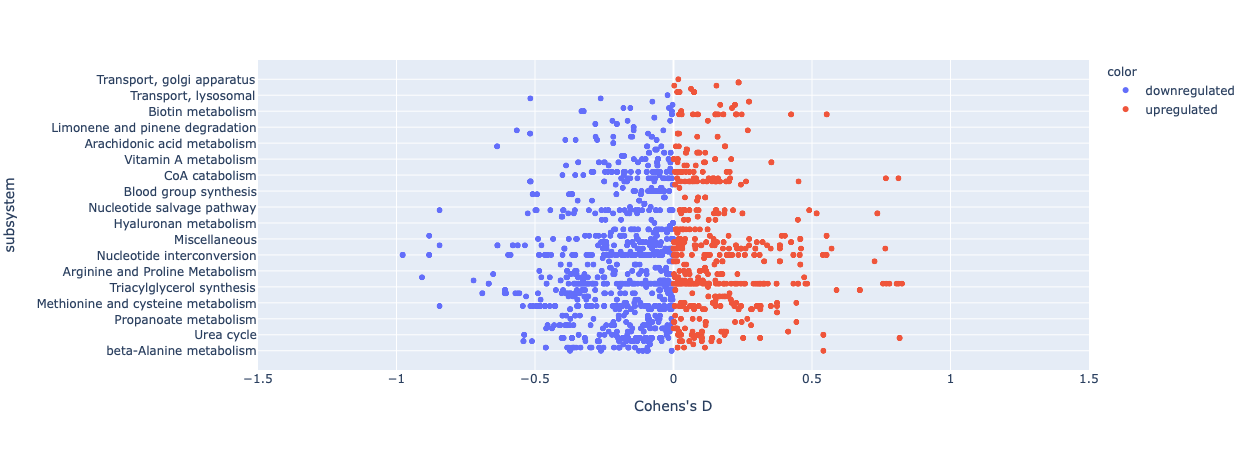

In [29]:
key = 'neurons'
plotly_category_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    #relevant_subsystems
)

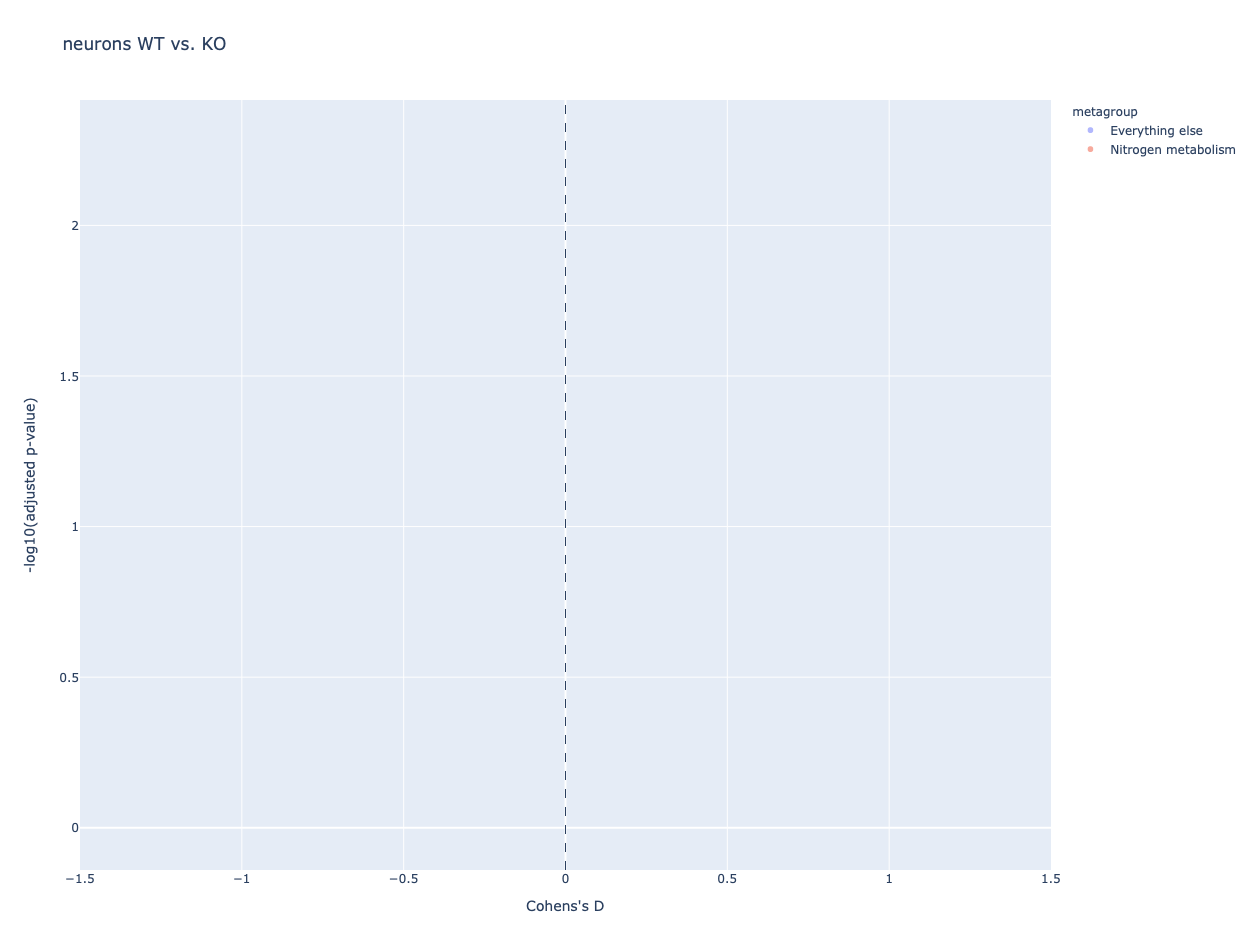

In [30]:
key = 'neurons'
plotly_vulcano_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    color = 'metagroup',
    pval_cutoff = None,
    pval_column = 'wilcox_pval'
)

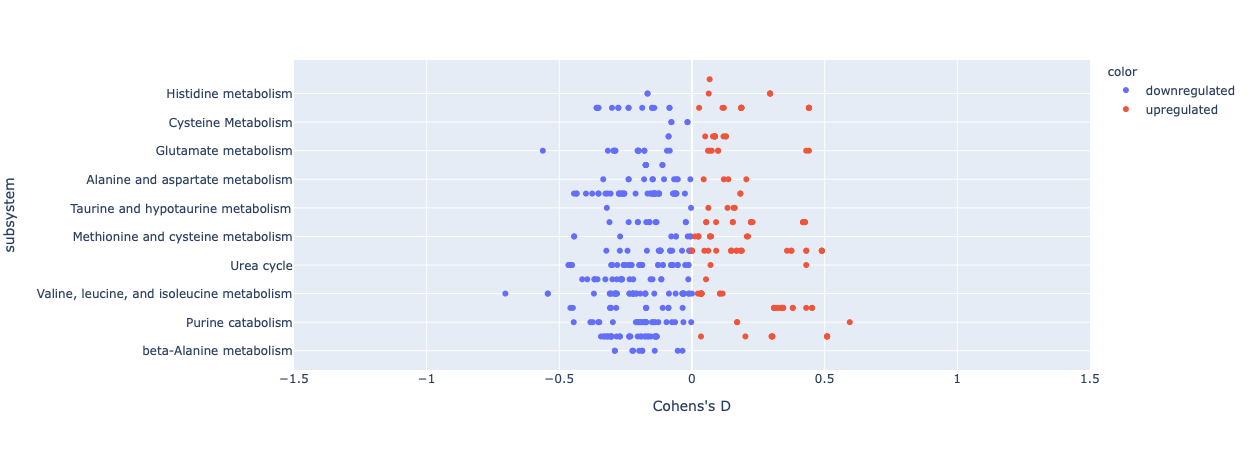

In [15]:
key = 'astrocytes'
plotly_category_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    relevant_subsystems
)

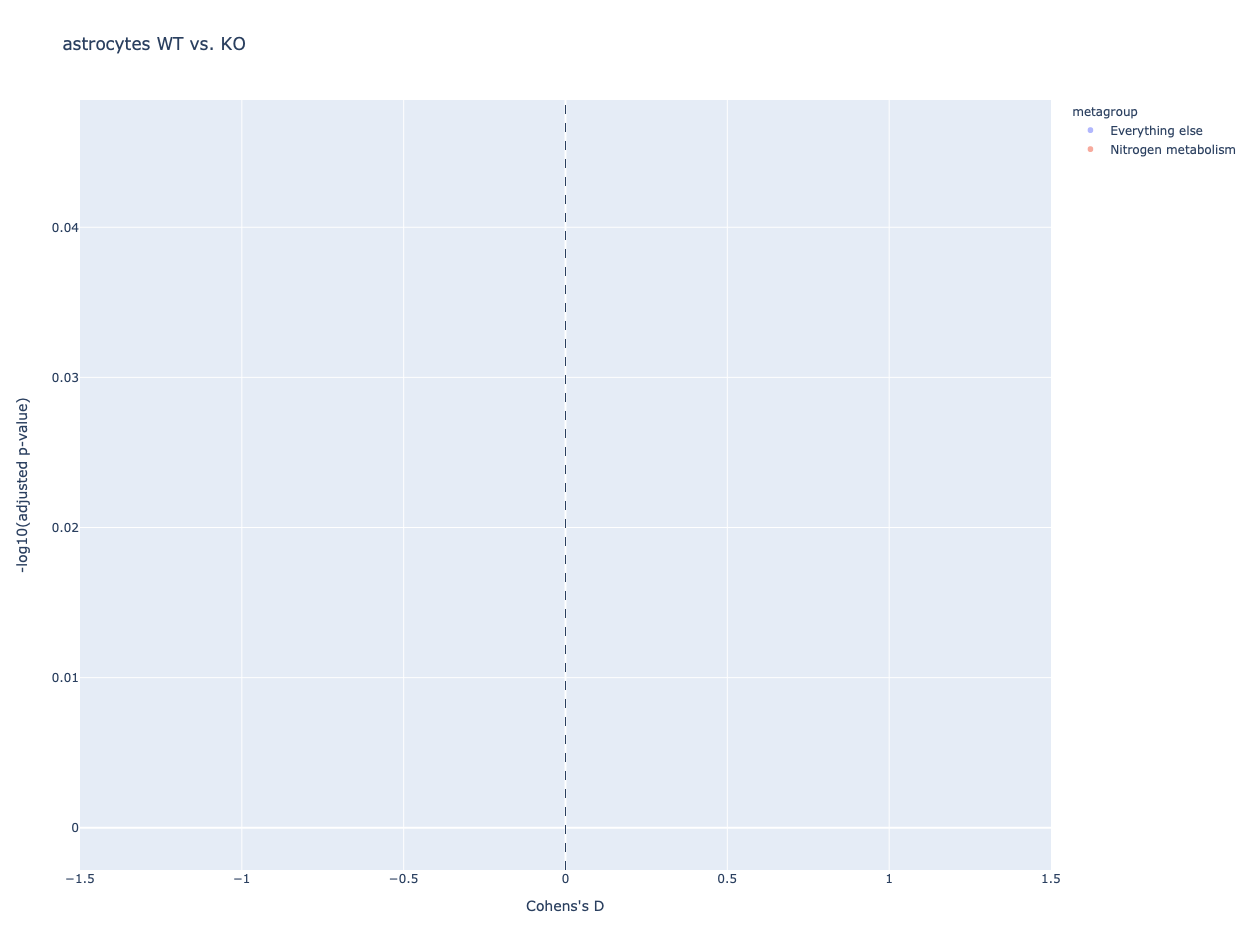

In [16]:
key = 'astrocytes'
plotly_vulcano_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    pval_cutoff = None
)

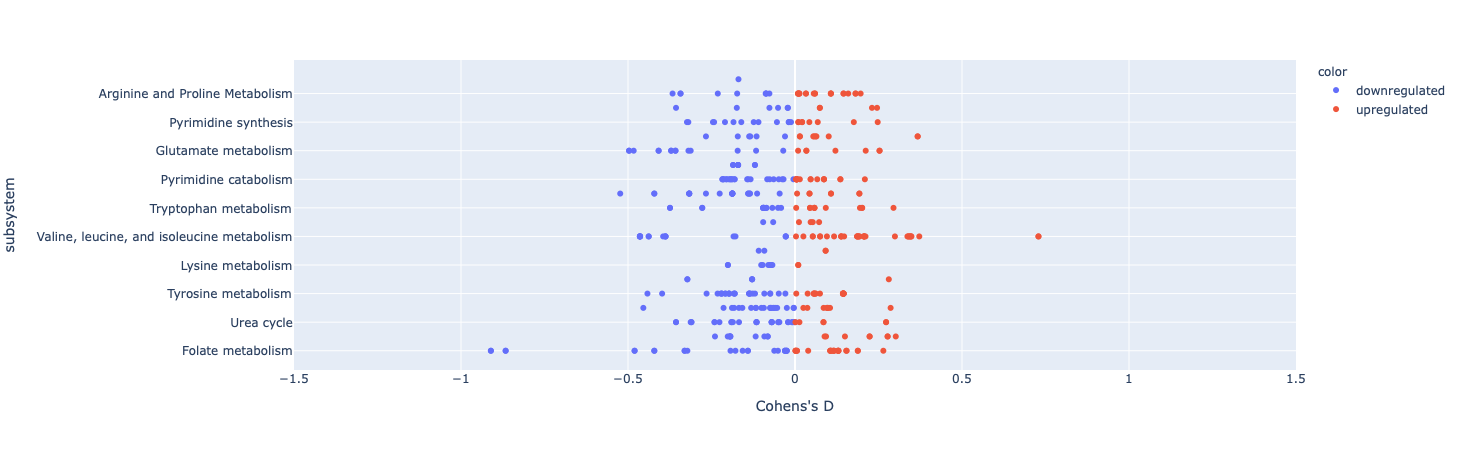

In [17]:
key = 'olfactory_cells'
plotly_category_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    relevant_subsystems
)

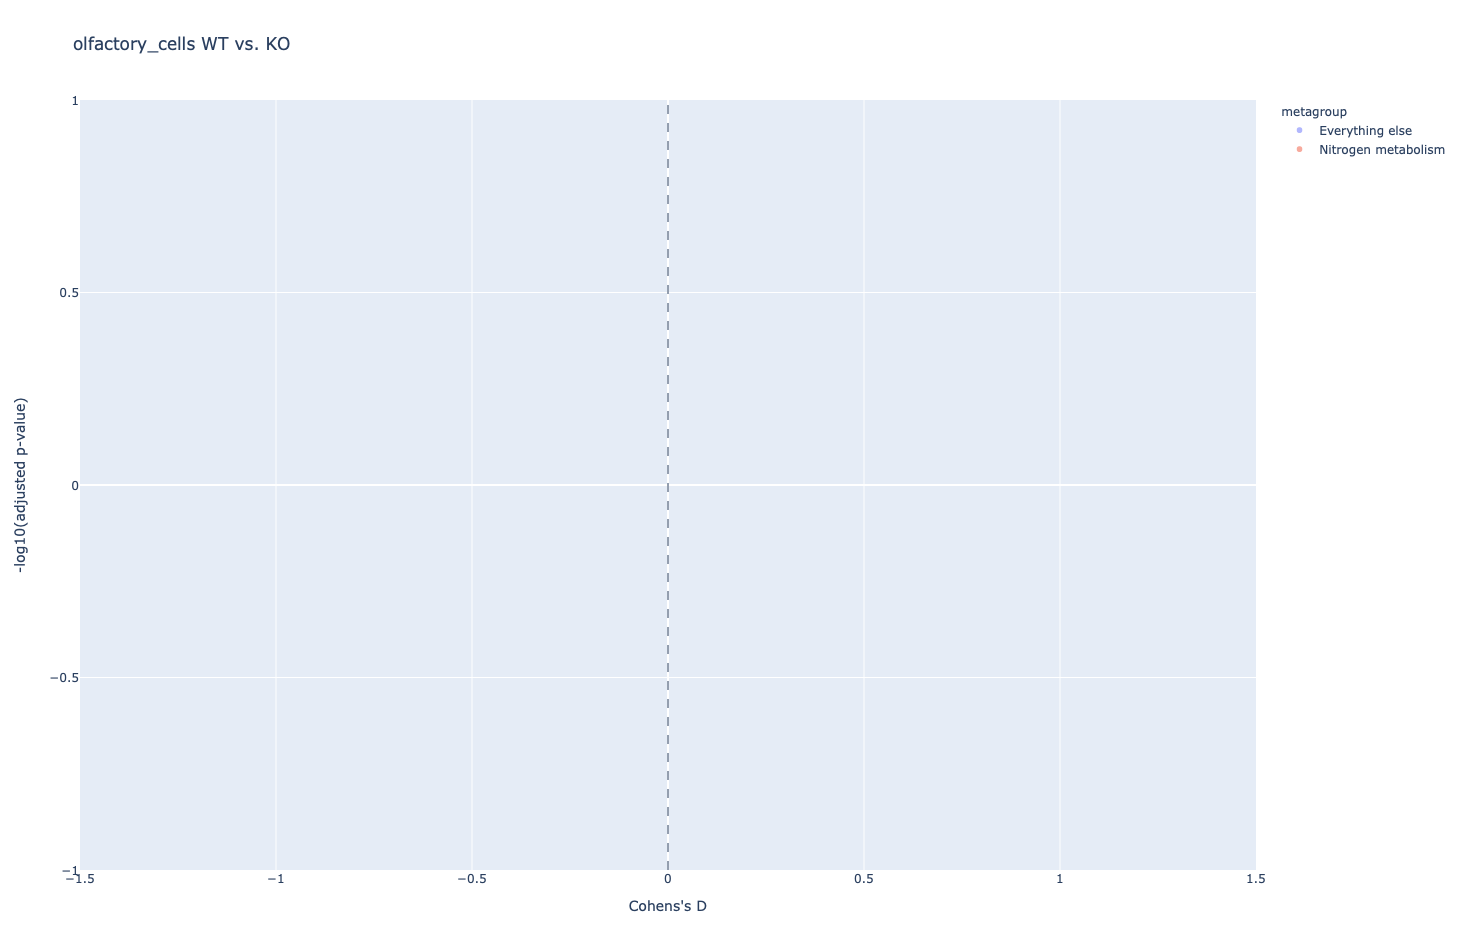

In [18]:
key = 'olfactory_cells'
plotly_vulcano_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    pval_cutoff = None
)

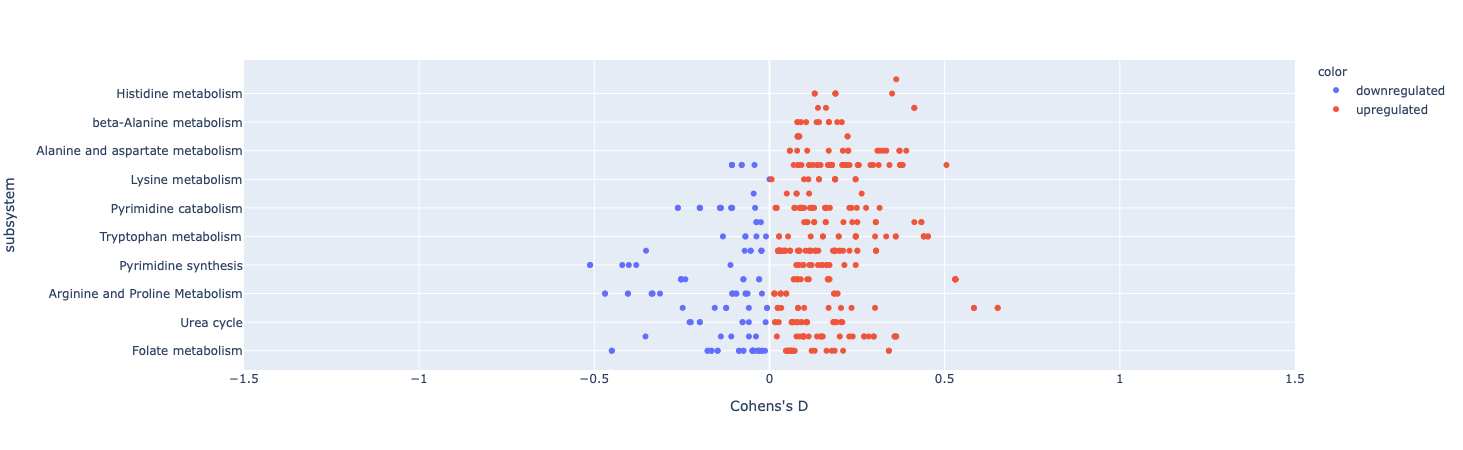

In [19]:
key = 'oligodendrytes'
plotly_category_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    relevant_subsystems
)

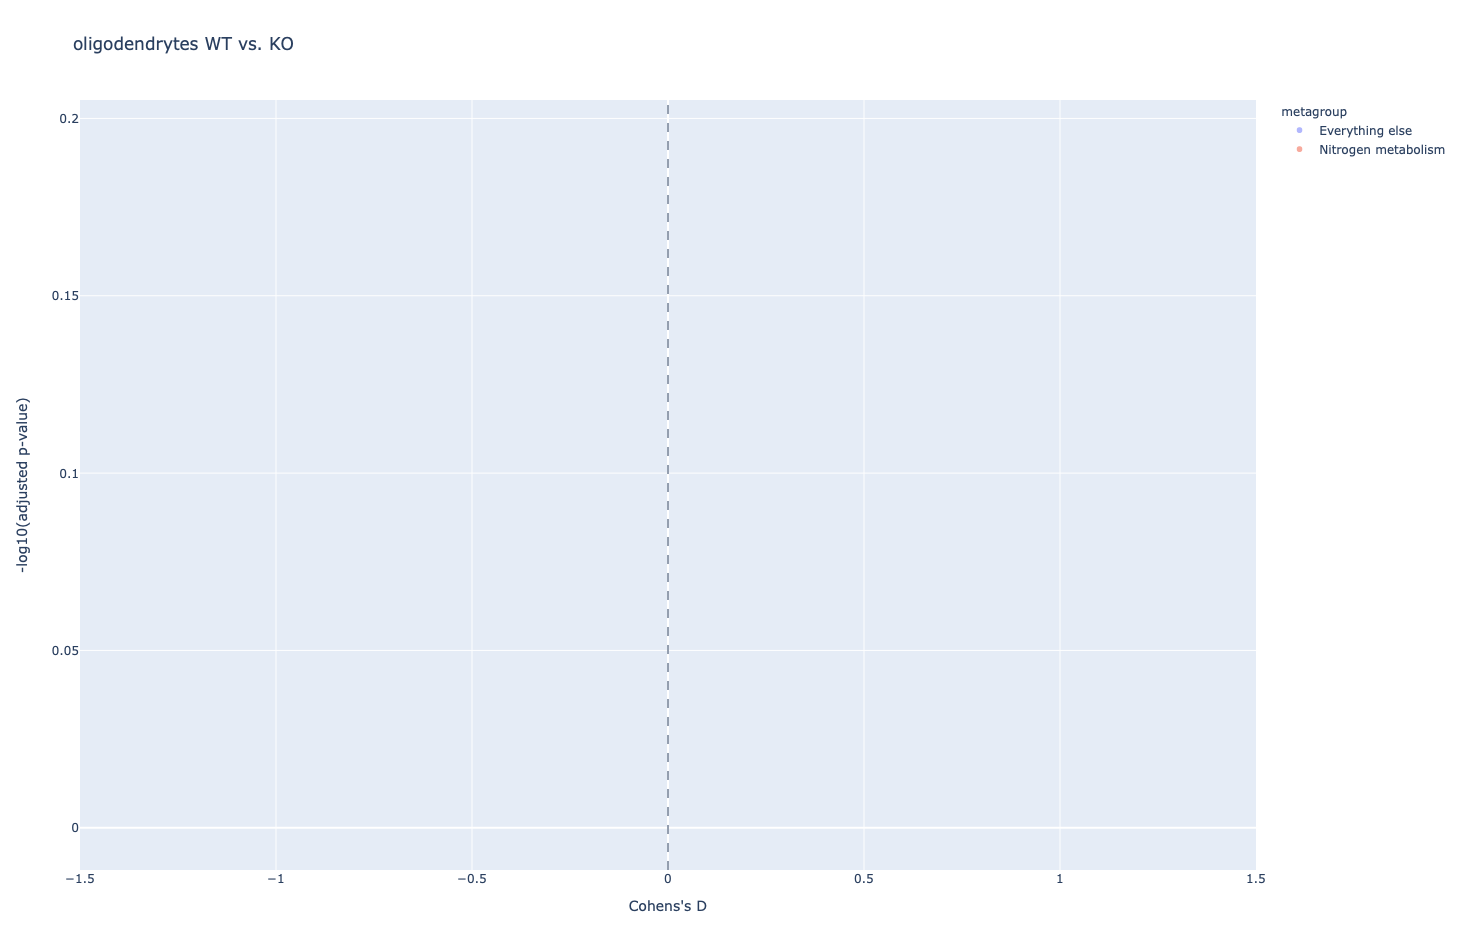

In [20]:
key = 'oligodendrytes'
plotly_vulcano_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    pval_cutoff = None
)

## Bulk RNA results

In [21]:
bulk_quant = ['featureCounts_rna', 'salmon_rna']
reaction_bulk = {
    key: load_reactions(
        f'../compass/{key}/ko/reactions.tsv.gz',
        f'../compass/{key}/wt/reactions.tsv.gz',
        'KO', 'WT'
    ) for key in bulk_quant
}
bulk_consistencies = {
    key: get_reaction_consistencies(rcs) for key, rcs in reaction_bulk.items()
}
bulk_test_results = {}
for key, rcs in bulk_consistencies.items():
    disease_label, control_label = ['KO', 'WT']
    disease_clusters = rcs.columns[rcs.columns.str.startswith(disease_label)]
    control_clusters = rcs.columns[rcs.columns.str.startswith(control_label)]
    wilcox_results = wilcoxon_test(
        rcs, 
        disease_clusters, 
        control_clusters
    )
    wilcox_results['metadata_r_id'] = ""
    for r in wilcox_results.index:
        if r in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r
        elif r[:-4] in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
        else:
            print("Should not occur")

    W = wilcox_results.merge(
        reaction_metadata, 
        how = 'left',
        left_on = 'metadata_r_id', 
        right_index = True, 
        validate = 'm:1'
    )
    W = W.loc[~W.EC_number.isna(), :]
    W['metagroup'] = W.subsystem.apply(
        lambda x: 'Nitrogen metabolism' if x in relevant_subsystems else 'Everything else'
    )
    bulk_test_results[key] = W

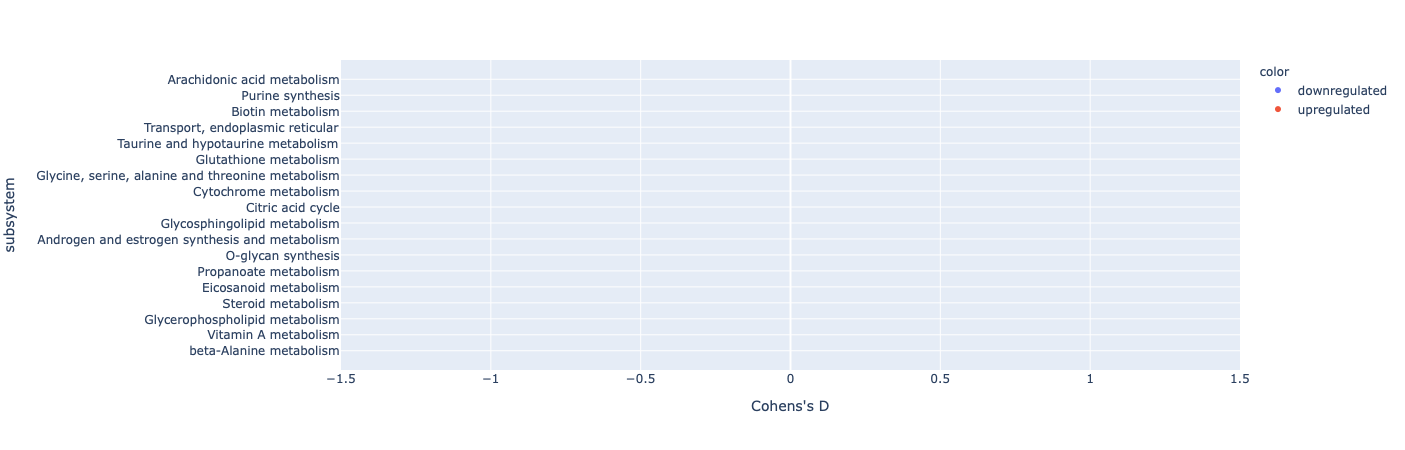

In [22]:
plotly_category_plot(
    bulk_test_results['salmon_rna'],
    key + ' ' + ' vs. '.join(['KO', 'WT']),
    #relevant_subsystems
)

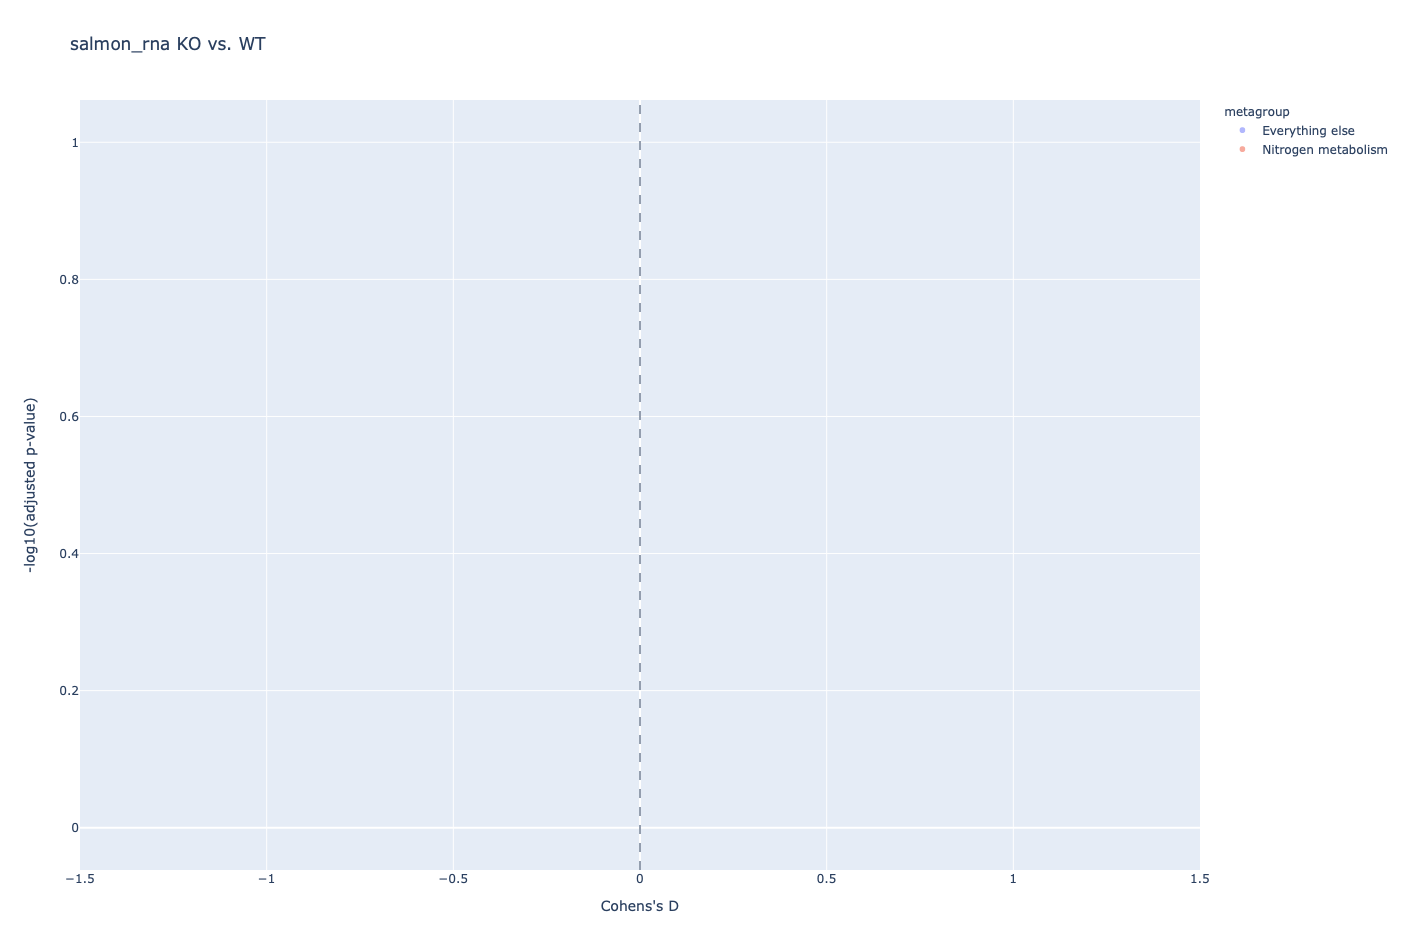

In [23]:
plotly_vulcano_plot(
    bulk_test_results['salmon_rna'],
    key + ' ' + ' vs. '.join(['KO', 'WT']),
    pval_cutoff = None,
    pval_column = 'wilcox_pval'
)

# Write results to file

In [30]:
df = reaction_consistencies['novarino_tpm']['neurons'].copy()
df['logFC'] = df.loc[:, df.columns.str.startswith('KO')].median(axis = 1) / df.loc[:, df.columns.str.startswith('WT')].median(axis = 1)
df = df.loc[:, ['logFC']]

for r in df.index:
    if r in reaction_metadata.index:
        df.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        df.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")
                
df['ec_number'] = df.metadata_r_id.apply(
    lambda x: reaction_metadata.at[x, 'EC_number']
)
df.dropna(
    subset = ['ec_number'],
    inplace = True
)
df = df.sort_index()
df

logFC     metadata_r_id ec_number
13DAMPPOX_pos         1.016497         13DAMPPOX   1.4.3.6
2DR1PP_pos            1.011031            2DR1PP  3.1.3.10
2HBO_neg              1.009523              2HBO  1.1.1.27
2HBO_pos              0.999164              2HBO  1.1.1.27
2OXOADOXm_pos         0.997916         2OXOADOXm  2.3.1.61
...                        ...               ...       ...
r1487_pos             1.030900             r1487   6.2.1.3
r1488_pos             1.017051             r1488   6.2.1.3
r1492_pos             1.030697             r1492   6.2.1.3
sink_citr(c)_pos      1.019971      sink_citr(c)  2.4.99.9
sink_pre_prot(r)_neg  0.999260  sink_pre_prot(r)  2.4.99.9

[2146 rows x 3 columns]

In [31]:
df.to_csv(
    '../raw/compass_results_neurons.tsv',
    sep = '\t'
)